In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import warnings
import seaborn as sb
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix


## Data Preprocessing

In [27]:
TRAIN_SET_PATH = "data/cs-training.csv"
TEST_SET_PATH = "data/cs-test.csv"
RANDOM_STATE = 628 # To be used whenever random seed is needed

In [3]:
train_df = pd.read_csv(TRAIN_SET_PATH).drop(columns="Unnamed: 0")
test_df = pd.read_csv(TEST_SET_PATH).drop(columns=["SeriousDlqin2yrs", "Unnamed: 0"])
print(train_df.shape)
print(test_df.shape)

(150000, 11)
(101503, 10)


In [4]:
train_df.info()
test_df.info()
# In both sets, the MonthlyIncome and NumberOfDependents fields contain null entries - these can be imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

#### Imputation using MICE

In [5]:
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
train_df_imputed = pd.DataFrame(mice_imputer.fit_transform(train_df), columns=train_df.columns)
test_df_imputed = pd.DataFrame(mice_imputer.fit_transform(test_df), columns=test_df.columns)
train_df_imputed.info()
test_df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  float64
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  float64
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  float64
 7   NumberOfTimes90DaysLate               150000 non-null  float64
 8   NumberRealEstateLoansOrLines          150000 non-null  float64
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  float64
 10  NumberOfDependents                    150000 non-null  float64
dtype

#### Outlier Treatment

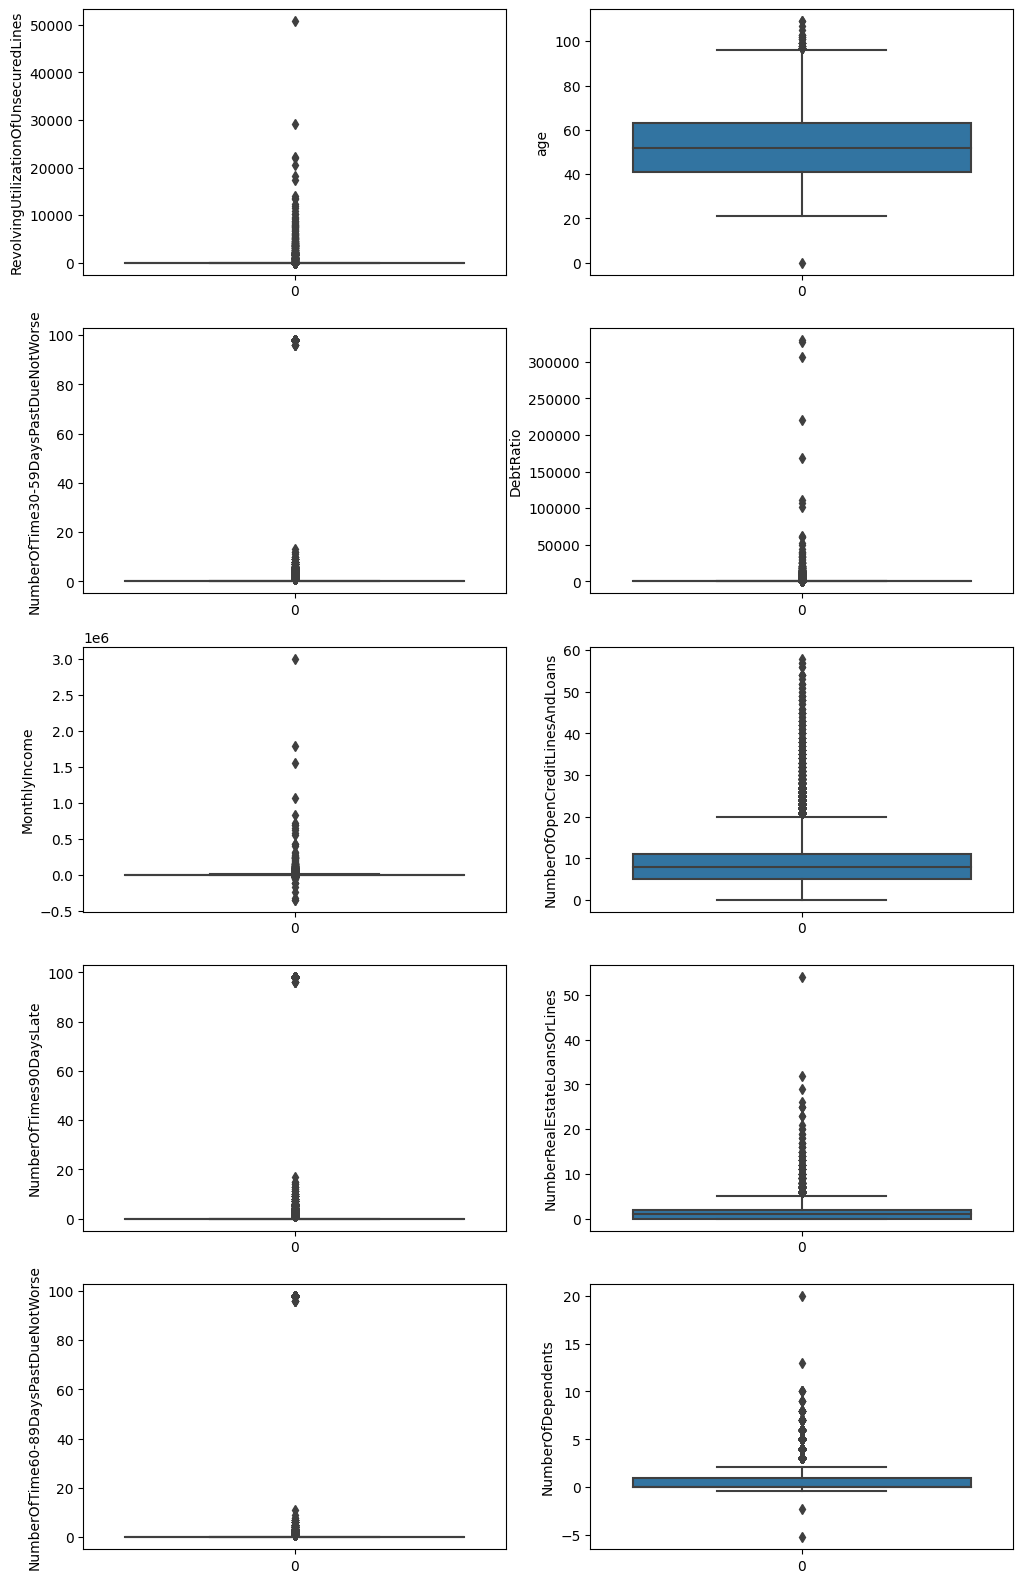

In [6]:
# Examine the nature of outliers using box-and-whisker plots before selecting an outlier treatment method
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,20))
train_df_drop_target = train_df_imputed.columns.drop("SeriousDlqin2yrs")
for i, col in enumerate(train_df_drop_target):
    plt.subplot(5, 2, i+1)
    sb.boxplot(data=train_df_imputed[col])
    plt.ylabel(col)

plt.show()

In [75]:
# Remove entries containing any value more than 3 standard deviations from the mean
train_df_filtered = train_df_imputed[(np.abs(stats.zscore(train_df_imputed.loc[: , train_df_imputed.columns!="SeriousDlqin2yrs"])) < 3).all(axis="columns")]
print(train_df_filtered.shape)
test_df_filtered = test_df_imputed[(np.abs(stats.zscore(test_df_imputed.loc[: , test_df_imputed.columns!="SeriousDlqin2yrs"])) < 3).all(axis="columns")]
print(test_df_filtered.shape)
train_df_filtered.sample(20)

(144556, 11)
(97505, 10)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
125553,0.0,0.366559,67.0,0.0,0.524836,3200.000000,6.0,0.0,2.0,0.0,0.0
80460,0.0,1.020767,50.0,1.0,0.188935,5313.000000,4.0,0.0,0.0,1.0,0.0
9457,0.0,0.008934,61.0,0.0,0.147655,11343.000000,11.0,0.0,2.0,0.0,0.0
22240,0.0,0.007744,41.0,0.0,0.503645,4800.000000,18.0,0.0,1.0,0.0,2.0
41652,0.0,0.000000,76.0,0.0,0.071054,10104.000000,7.0,0.0,1.0,0.0,0.0
71817,0.0,0.358412,54.0,0.0,4076.000000,4306.560711,18.0,0.0,1.0,0.0,2.0
103077,0.0,0.031035,80.0,0.0,0.012476,2083.000000,3.0,0.0,0.0,0.0,0.0
31467,0.0,0.616256,22.0,0.0,0.148823,2250.000000,3.0,0.0,0.0,0.0,0.0
102031,0.0,0.113569,47.0,0.0,0.131878,5815.000000,8.0,0.0,1.0,0.0,1.0
113950,0.0,0.016725,74.0,0.0,968.000000,6075.453620,11.0,0.0,1.0,0.0,0.0


## Part 1: Data Analysis

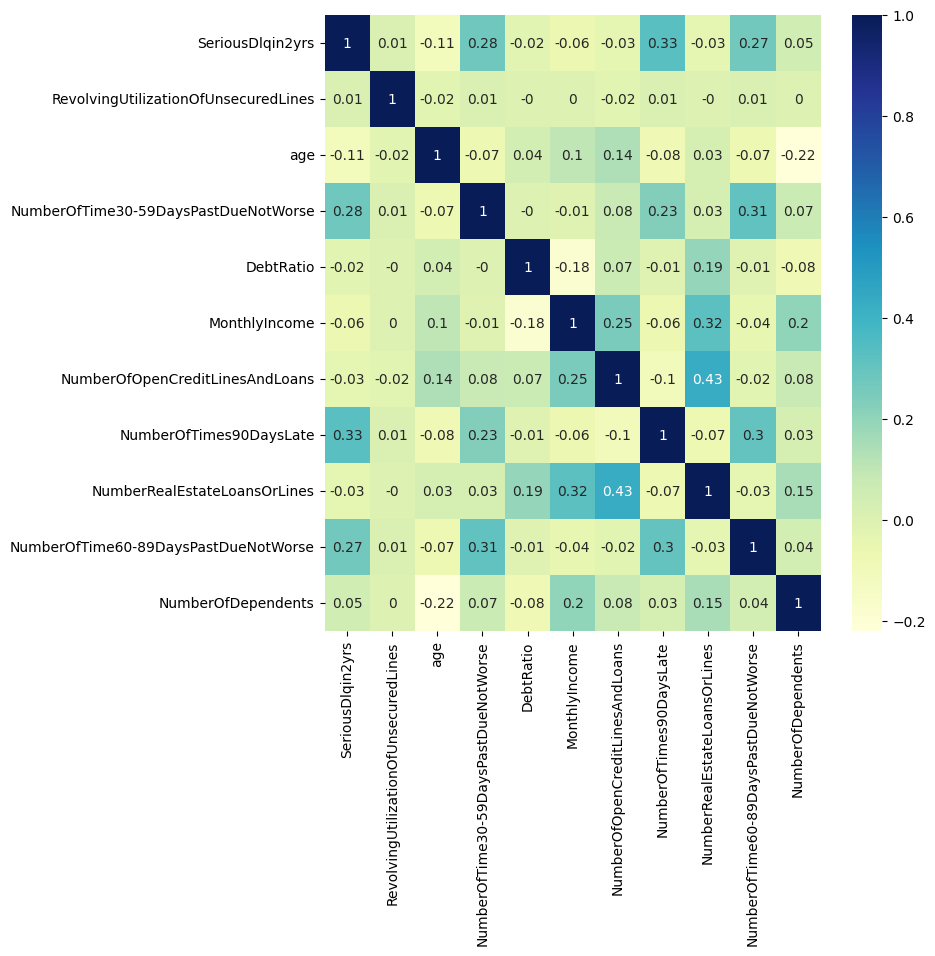

In [69]:
corr_matrix = train_df_filtered.corr().round(2)
fig, axs = plt.subplots(figsize=(8,8))
sb.heatmap(corr_matrix, cmap="YlGnBu", xticklabels = corr_matrix.columns, yticklabels = corr_matrix.columns, annot=True)
fig.show()

#### Question 1

This correlation matrix indicates that the following factors, in descending order, have the strongest positive correlation with probability of loan default:
1. NumberOfTimes90DaysLate
2. NumberOfTime30-59DaysPastDueNotWorse
3. NumberOfTime60-89DaysPastDueNotWorse

This is expected because each of these three attributes reflect tardiness in personal financial practice. This, in turn, may correspond to a higher probability of financial distress.


The following factors, in descending order, have the strongest negative correlation with probability of loan default:
1. Age
2. MontlyIncome

This is expected because financial stability tends to increase with age (anectodatally) and monthly income further reflects this financial stability. Financial stability can be thought of as an opposite to financial distress, explaining this negative correlation.

#### Question 2

We can analyse interaction effects using correlation values from the matrix above. Correlation indicates the degree of relatedness between two given variables. Positive values indicate that a higher value in one variable tends to correspond to higher values in the other. Negative values indicate the inverse relationship. Large magnitudes indicate a strong relationship; small magnitudes indicate a weak relation. These facts can be used to extract meaning from the matrix:
1. There is a relatively strong positive correlation between the number of real estate and credit lines/loans that are open. This is sensible because real estate lines/loans are a subset of credit lines/loans. An increase in the former implies an increase in the latter.
2. There is a relatively strong positive correlation between the number of open credit/real estate lines/loans and monthly income. This may be explained by the fact that those with greater monthly income are in a better position (and thus more likely to) to acquire credit lines/loans.
3. Monthly income and number of dependents have a positive correlation. This may be because those with more dependents require a greater income to support those dependents.
4. There is a strong negative relation between monthly income and debt ratio. This is expected because those with higher monthly income would need to acquire fewer assets via debt.
5. Age is negatively correlated to the number of dependents. This is because as an individual ages, their children tend to become increasingly independent (financially).
6. There is a strong positive correlation between the number of times one is 60-89 days overdue and the number of times one is 90+ days overdue. This relationship doesn't imply causation between the two variables; instead, it likely emerges from the fact that the underlying causes for both issues are similar. This can be verified by noting the rows for each of these two variables: the rows have a very similar heat pattern, indicating potentially similar root causes.

#### Question 3

##### Creating a pairplot to visually observe patterns
These plots can help reveal whether techniques like SVM are likely to generate strong fits, or whether more complex techniques should be attempted. In this case, we see relatively strong separating lines for some pairings, and far more arbitrary arrangments in others (blue represents negatives, orange represents positives). This means that a technique like SVM may not be able to capture the complexity of the dataset (it will underfit).

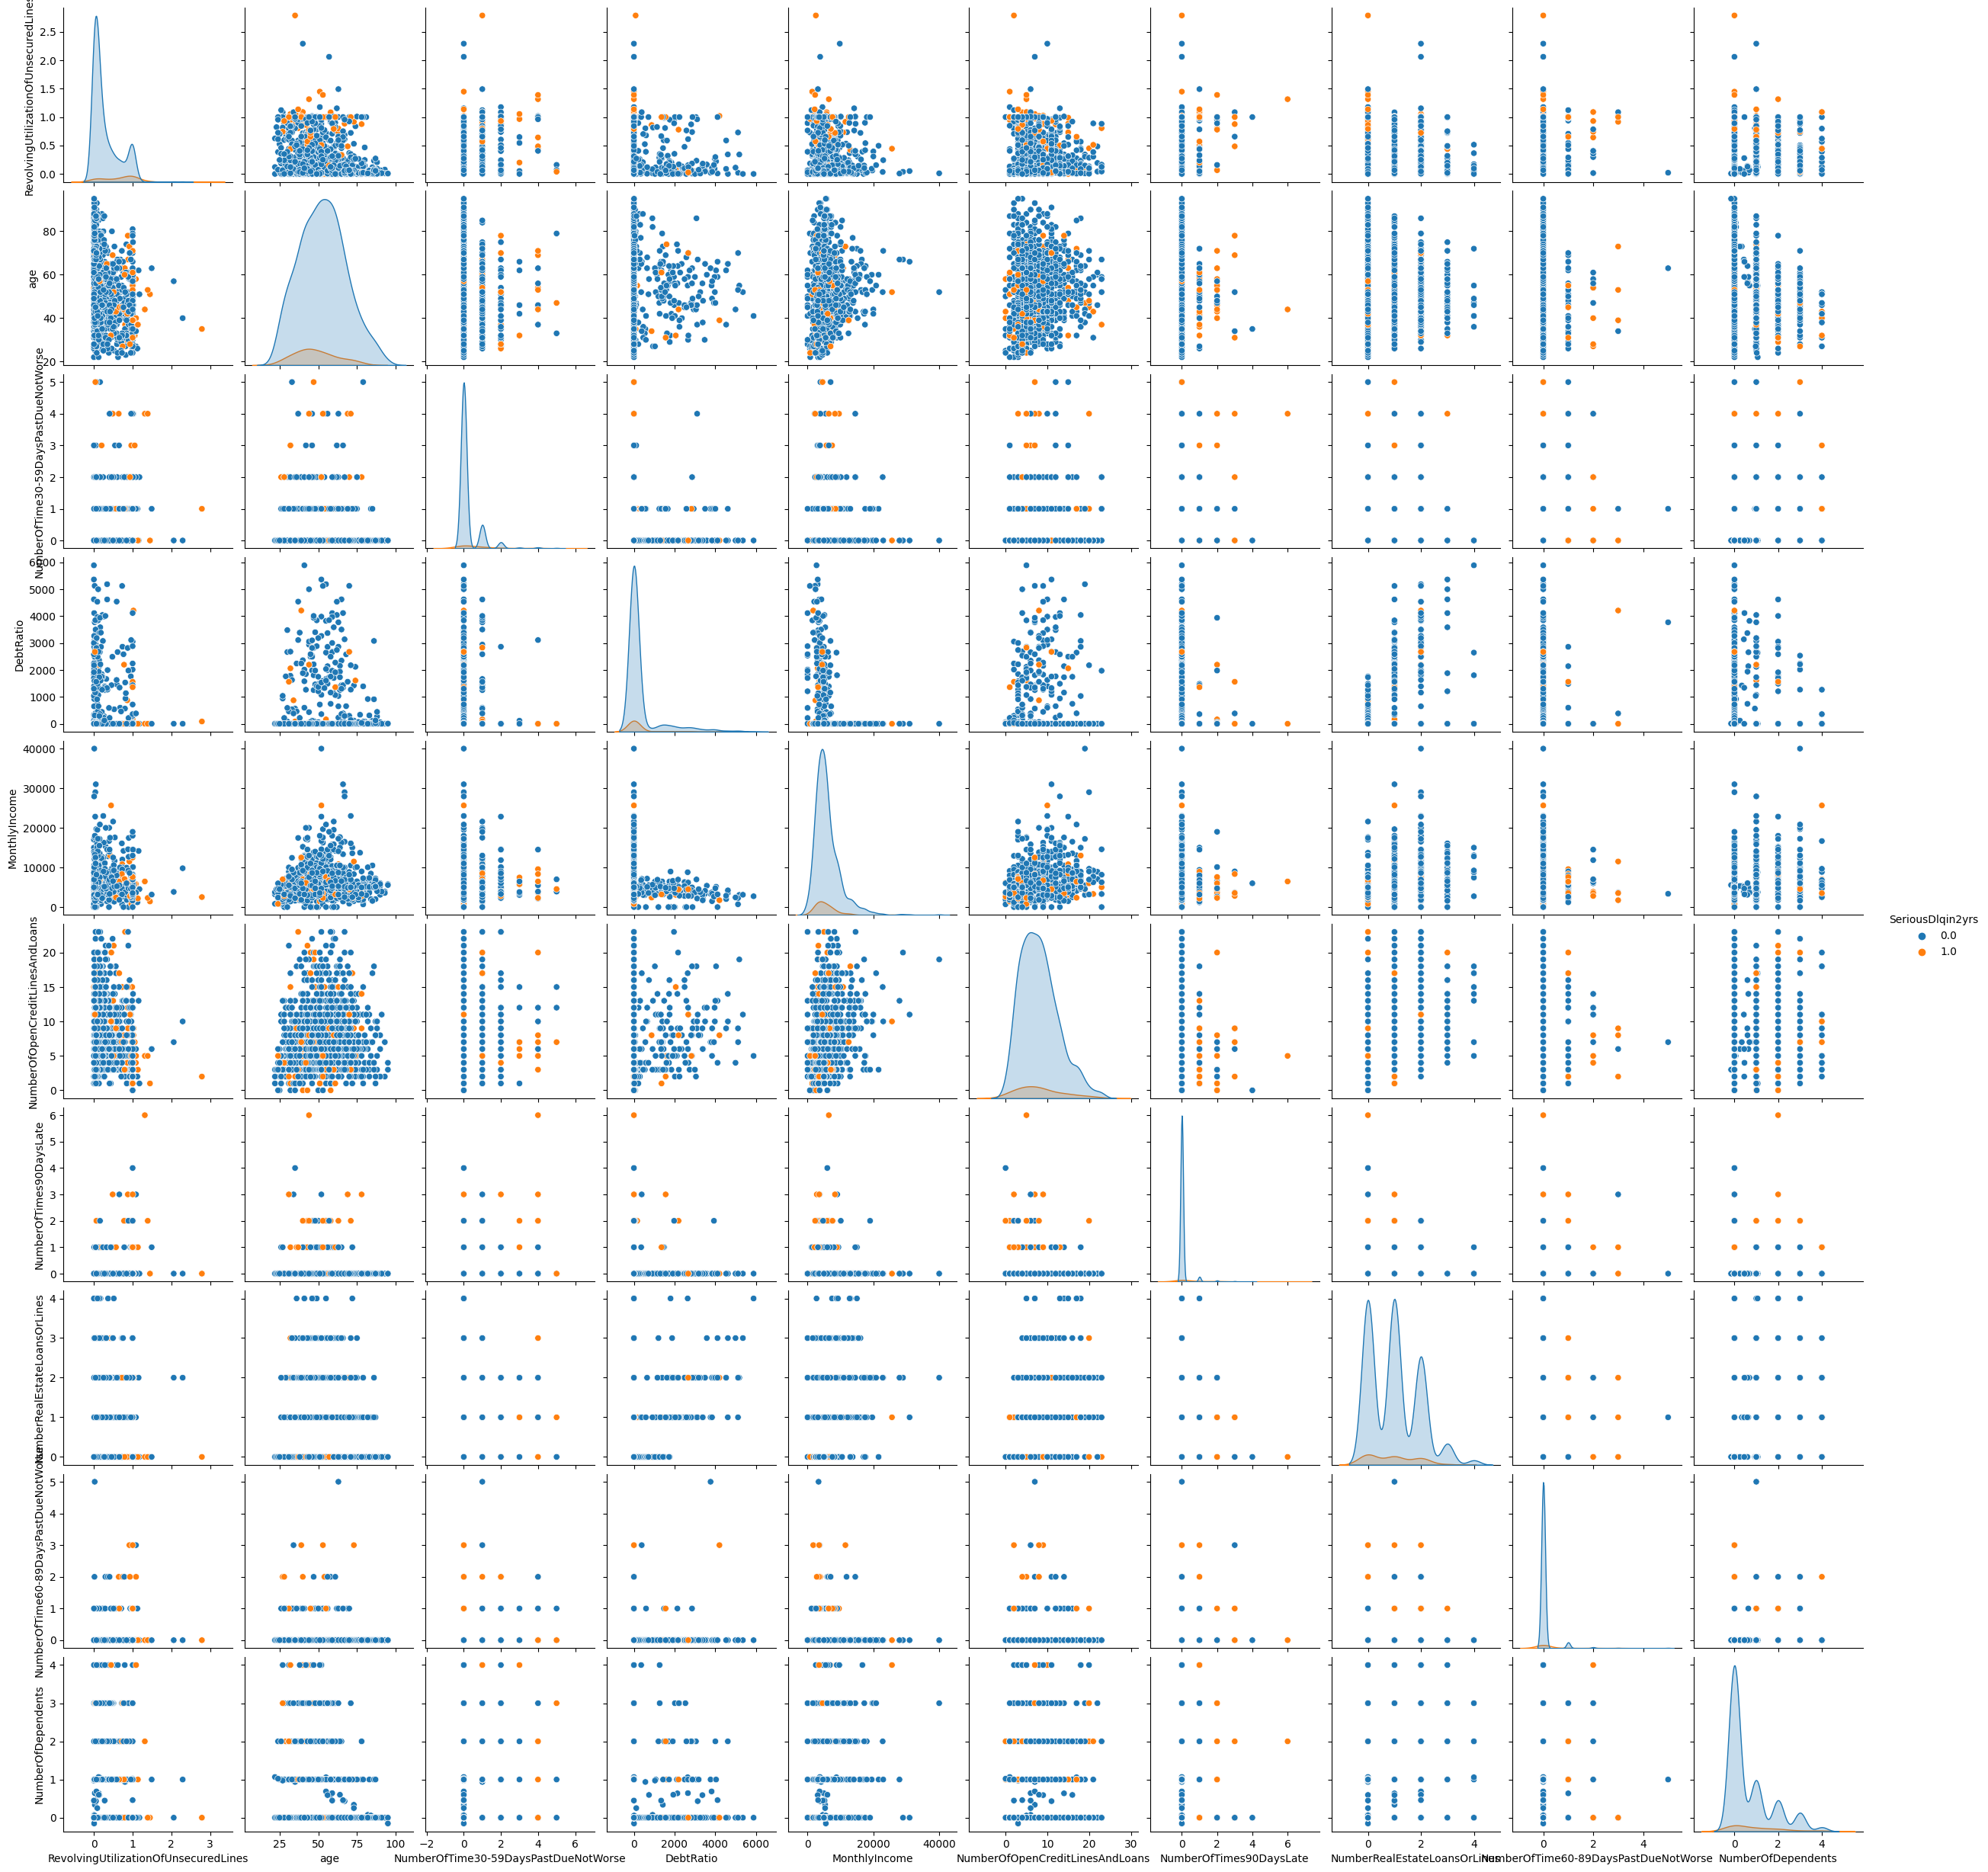

In [70]:
sb.pairplot(train_df_filtered.sample(n=1000), hue="SeriousDlqin2yrs")

##### Observing distribution of variables

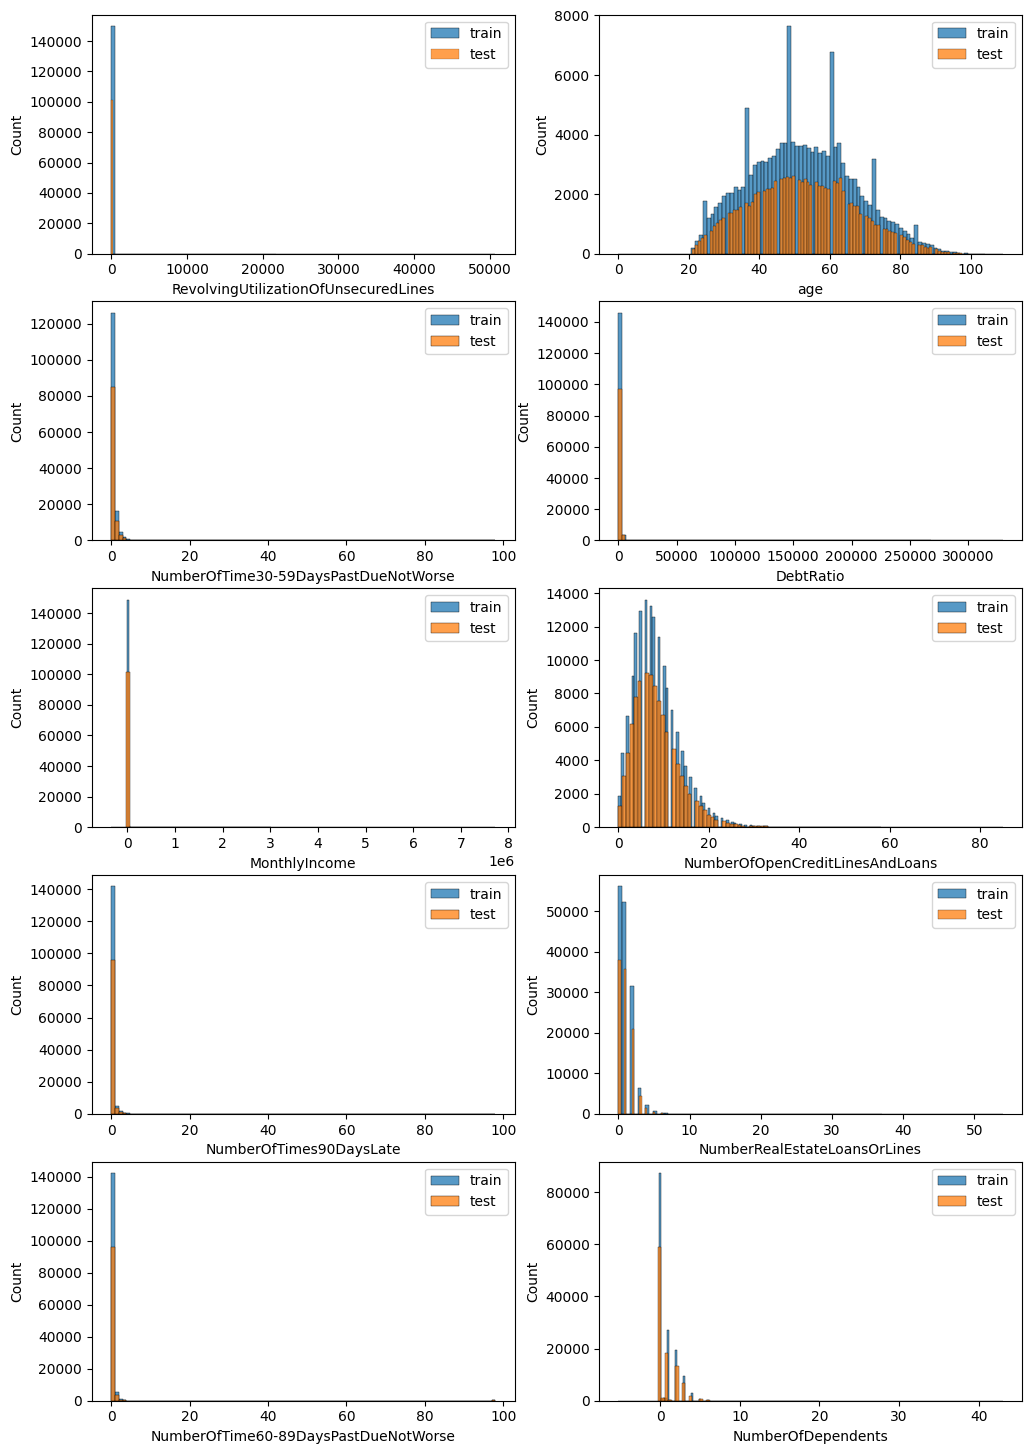

In [17]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,18))
cols = train_df_imputed.columns.drop("SeriousDlqin2yrs")
for i, col in enumerate(cols):
    plt.subplot(5, 2, i+1)
    sb.histplot(data=train_df_imputed, x=col, bins=100, label="train")
    sb.histplot(data=test_df_imputed, x=col, bins=100, label="test")
    plt.legend()

plt.show()

We can see in the graphs above that the ranges of each variable are vastly different. It is therefore necessary to normalize or standardize the data, as performed below. Note that I use standardization instead of normalization because standardization is less vulnerable to outliers, which may be significant as per the plots above (see plot on bottom left for an example).

In [71]:
train_df_filtered.loc[:, train_df_filtered.columns != "SeriousDlqin2yrs"] = train_df_filtered.loc[:, train_df_filtered.columns != "SeriousDlqin2yrs"].apply(lambda x: (x - x.mean()) / x.std())
test_df_filtered = test_df_filtered.apply(lambda x: (x - x.mean()) / x.std())
train_df_filtered.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,0.0,0.074361,-0.826750,-0.350897,-0.345175,-0.812749,-0.901915,-0.191029,-1.016573,-0.196871,0.271416
2,0.0,0.032678,-0.961534,1.099944,-0.345217,-0.703524,-1.337014,1.917744,-1.016573,-0.196871,-0.695109
3,0.0,-0.026488,-1.500672,-0.350897,-0.345273,-0.639768,-0.684366,-0.191029,-1.016573,-0.196871,-0.695109
5,0.0,-0.029364,1.464586,-0.350897,-0.344883,-0.590345,-1.119465,-0.191029,0.055105,-0.196871,0.271416
6,0.0,-0.016467,0.318918,-0.350897,6.207007,-0.822817,-0.031718,-0.191029,2.198462,-0.196871,-0.695109


##### Analysing Class Balance

array([[<AxesSubplot: title={'center': 'SeriousDlqin2yrs'}>]],
      dtype=object)

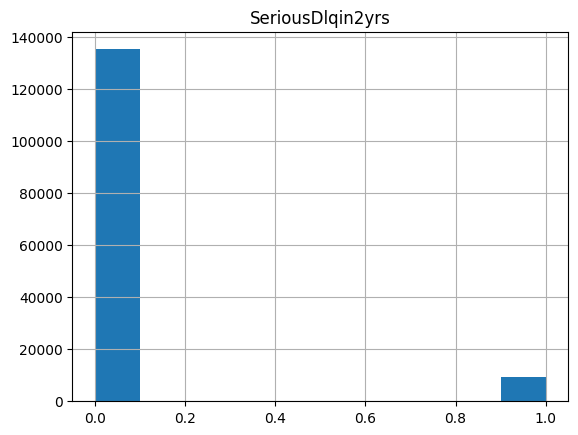

In [72]:
train_df_filtered.hist(column="SeriousDlqin2yrs")

This histogram shows that the number of negatives far exceeds the number of positives. We can try to adjust the class balance using a technique called synthetic minority oversampling, which creates new synthetic datapoints in between k nearest neighbours of arbitrary datapoints in the minority class, for an integer k. It is advisible to oversample instead of undersample because the number of datapoints in the minority class is very little (under 10000).

In [73]:
X = train_df_filtered.loc[:, train_df_filtered.columns != "SeriousDlqin2yrs"].to_numpy()
y =  train_df_filtered.loc[:, train_df_filtered.columns == "SeriousDlqin2yrs"].to_numpy().squeeze()
sm = SMOTE(random_state=RANDOM_STATE)
X_balanced, y_balanced = sm.fit_resample(X, y)

In [74]:
print(X_balanced.shape)
print(y_balanced.shape)

(270320, 10)
(270320,)


## Part 2: The Model

We select random forest over decision trees to minimize the risk of overfitting. Unfortunately, we lose out on some interpretability.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(216256, 10) (216256,)
(54064, 10) (54064,)


In [30]:
model = RandomForestClassifier()

In [51]:
params =  {
    'max_depth': [6, 8, 10],
    'n_estimators': [12, 16, 20]
}
grid_cv = GridSearchCV(model, params, cv=5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10], 'n_estimators': [12, 16, 20]})

In [52]:
model_best = grid_cv.best_estimator_
grid_cv.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=16)

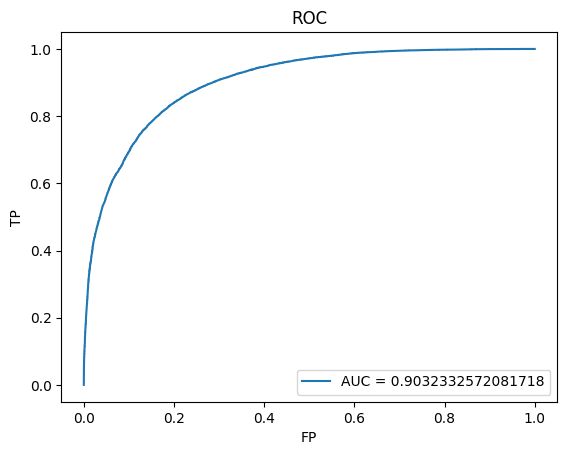

In [62]:
# Find AUC for test set to evaluate model
y_proba = model_best.predict_proba(X_test) # Use predict_proba because we want continuous results
y_pred = y_proba[:,1]
fp, tp, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fp, tp)
plt.title('ROC')
plt.plot(fp, tp, label = 'AUC = ' + str(roc_auc))
plt.legend(loc = 'best')
plt.ylabel('TP')
plt.xlabel('FP')
plt.show()

In [76]:
# We can assess the model with classification metrics
y_pred_classes = model_best.predict(X_test) # Use class-wise predictions instead of continuous numeric predictions (otherwise, the classification metrics below are meaningless)
precision, recall, fscore, _ = precision_recall_fscore_support(y_true = y_test, y_pred = y_pred_classes, average="macro")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()
specificity = tn/(tn+fp)
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)
print("Specificity:", specificity)

Precision: 0.8203578543651024
Recall: 0.8202271447061644
F-score: 0.8202267356346985
Specificity: 0.8108358673885634


#### Question 1

One of the key metrics is AUC (this is explained in Q2). I chose not to use accuracy because it is only meaningful on balanced datasets. While I balanced the training dataset here, there is no guarantee of a balanced test dataset in the real-world (in fact, we shouldn't expect this at all).
I also employed precision, recall, and specificity (sensitivity was not used since it is the same as recall in this case). Precision is a measure of how many of the predicted positives were actually positive. Recall measures how many of the total positives were actually predicted as such. Specificity measures the same but for negatives (it is the complement of recall). These three metrics were used because they capture the problem framing. For instance, precision can inform how confident we are when we predict someone will default on a loan.

#### Question 2
AUC stands for area under curve. It is the area under the ROC (receiver operating characteristic) curve. AUC is a measure of the separability of the dataset as classified by the model. A score close to one indicates that the model can separate positives and negatives well. A score of 0.5 indicates that the rate of false positives tends to be equal to the rate of true positives (i.e. a weak model). Note that each "point" on the ROC curve corresponds to a different classification threshold.
AUC may have been chosen for this contest due to the heavy class imbalance. While I attempted to correct for this, some may have chosen not to. A metric like AUC would be invariant to this imbalance and provide a more fair assessment.

#### Question 3
I tried logistic regression prior to random forest (not shown). The results were slightly worse, perhaps because the model could not accurately capture the complexity of the data. I also tried SVM, which gave similar results as with logistic regression.

I then considered random forest and decision tree methods. I selected random forest over a classic decision tree because I wanted to reduce the chances of overfitting. This compromised interpretability, unfortunately. Given additional information about the problem, I may have prioritized explainability more heavily.

Once I had settled on random forest, I used Grid Search on a set of 24 different parameter configurations (some are not shown). The best result is shown above.


#### Question 4
Random Forest, though accurate, was not as interpretable as the other methods I tried. This is a classic issue in machine learning: more accurate models, like neural networks, tend to be less explainable. Thankfully, emerging research in XAI is combatting these issues.
Based on my regression and SVM approaches, in addition to my initial data analysis, age, monthly income, 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', and 'NumberOfTimes90DaysLate' are strong predictors of one's likelihood of defaulting a loan.